In [2]:
pip install autocorrect

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 622.8/622.8 kB 6.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for autocorrect: filename=autocorrect-2.6.1-py3-none-any.whl size=622364 sha256=b2b4c4ef102b922b6c715a4ca57d7ad9a37c8b7fdd1945d9483ead881bb7c006
  Stored in directory: /root/.cache/pip/wheels/b5/7b/6d/b76b29ce11ff8e2521c8c7dd0e5bfee4fb1789d76193124343
Successfully built autocorrect


In [3]:
pip install emoji

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 421.5/421.5 kB 5.5 MB/s eta 0:00:00


In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from textblob import TextBlob as tb
from autocorrect import Speller as sp
import emoji
import nltk
from nltk.tokenize import word_tokenize as wt,sent_tokenize as st
from nltk.corpus import stopwords
from nltk import PorterStemmer,LancasterStemmer,SnowballStemmer
from nltk import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer

from sklearn.pipeline import Pipeline ,make_pipeline
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import FunctionTransformer,PowerTransformer

In [5]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

### 1.Problem Statement
#### Create a model for predict that coment/text belongs to which type of tweet (positive/negative/neutral)

### 2.Data Collection

In [9]:
# take a data set from kaggle which used to classify emotions based on text/comments.
# Convert column names correctly as mensioned in problem statement.
data = pd.read_csv(r"/content/drive/MyDrive/twitter analysis/twitter.csv",encoding="latin-1",header = None,names=["Target","UserId","Date","Flag","UserName","Text"])
data

,Target,UserId,Date,Flag,UserName,Text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
...,...,...,...,...,...,...
1599995,4,2193601966,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,AmandaMarie1028,Just woke up. Having no school is the best fee...
1599996,4,2193601969,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,TheWDBoards,TheWDB.com - Very cool to hear old Walt interv...
1599997,4,2193601991,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,bpbabe,Are you ready for your MoJo Makeover? Ask me f...
1599998,4,2193602064,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,tinydiamondz,Happy 38th Birthday to my boo of alll time!!! ...


### 3.EDA Before pre-processing

In [11]:
data.shape   # data contains 1600000 rows and 6 columns

(1600000, 6)

In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 6 columns):
 #   Column    Non-Null Count    Dtype 
---  ------    --------------    ----- 
 0   Target    1600000 non-null  int64 
 1   UserId    1600000 non-null  int64 
 2   Date      1600000 non-null  object
 3   Flag      1600000 non-null  object
 4   UserName  1600000 non-null  object
 5   Text      1600000 non-null  object
dtypes: int64(2), object(4)
memory usage: 73.2+ MB


In [17]:
data.isnull().sum()

Target      0
UserId      0
Date        0
Flag        0
UserName    0
Text        0
dtype: int64

In [19]:
data.duplicated().sum()

0

In [ ]:
data["Target"] = data["Target"].map({0:"Negative",4 : "Positive"})    # Covert class labels 0 as negative and 4 as positive

In [20]:
data.Target.unique()   # unique values for class label

array(['Negative', 'Positive'], dtype=object)

In [21]:
data.Target.value_counts() # 800000 rows belongs to 0 (Negative) and 800000 rows belongs to 4 (Positive)

Negative    800000
Positive    800000
Name: Target, dtype: int64

In [13]:
# as per my problem statement i don't want some columns,beacuase there is no use for those columns for solve my problem statemnet
# split my data into featue variables and class variables
fv = data.iloc[:,-1]
cv = data.iloc[:,0]

In [14]:
fv.head()

0    @switchfoot http://twitpic.com/2y1zl - Awww, t...
1    is upset that he can't update his Facebook by ...
2    @Kenichan I dived many times for the ball. Man...
3      my whole body feels itchy and like its on fire 
4    @nationwideclass no, it's not behaving at all....
Name: Text, dtype: object

In [22]:
cv.head()

0    0
1    0
2    0
3    0
4    0
Name: Target, dtype: int64

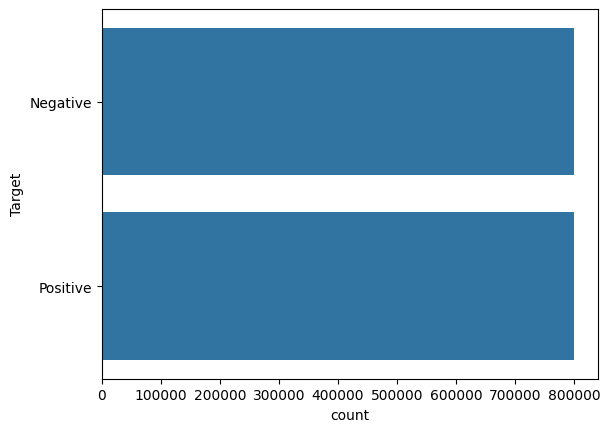

In [24]:
sns.countplot(data.Target)
plt.show()

In [ ]:
cv = cv.map({"Negative":0,"Positive":4})     # convert class variables negative as 0 and positive as 4.

In [28]:
x_train,x_test,y_train,y_test = train_test_split(fv,cv,test_size=0.2,stratify=cv)

In [30]:
x_train.shape

(1280000,)

In [31]:
x_test.shape

(320000,)

### 4. Pre-processing

In [32]:
# basic pre=processing steps

def lowers(x):
    return x.str.lower()

def html(x):
    return x.apply(lambda x:re.sub("<.+?>"," ",x))

def url(x):
    return x.apply(lambda x:re.sub("https[s]?://.+? +"," ",x))

def unw(x):
    return x.apply(lambda x:re.sub("[]()*\-.:,@#$%&^!?/0-9']"," ",x))

In [41]:
def lemma(x):
  list_stp = stopwords.words("english")  # list_stp contains group of stop words.
  wl=WordNetLemmatizer()

  def lemmatize_text(text):
        words = wt(text)
        lemmatized_words = [wl.lemmatize(word, pos="v") for word in words if word not in list_stp]
        return " ".join(lemmatized_words)

  return x.apply(lemmatize_text)

In [42]:
#lemma(fv)

0          @ switchfoot http : //twitpic.com/2y1zl - Awww...
1          upset ca n't update Facebook texting ... might...
2          @ Kenichan I dive many time ball . Managed sav...
3                            whole body feel itchy like fire
4          @ nationwideclass , 's behave . 'm mad . ? I c...
                                 ...                        
1599995             Just wake . Having school best feel ever
1599996    TheWDB.com - Very cool hear old Walt interview...
1599997                 Are ready MoJo Makeover ? Ask detail
1599998    Happy 38th Birthday boo alll time ! ! ! Tupac ...
1599999    happy # charitytuesday @ theNSPCC @ SparksChar...
Name: Text, Length: 1600000, dtype: object

In [45]:
# create a pipeline for pre-processing the data
pre_pro_pi = Pipeline([("lower",FunctionTransformer(lowers)),("html",FunctionTransformer(html)),
                       ("url",FunctionTransformer(url)),("unw",FunctionTransformer(unw)),("advance",FunctionTransformer(lemma))])

In [46]:
pre_pro_pi

Pipeline(steps=[('lower',
                 FunctionTransformer(func=<function lowers at 0x7856abe52560>)),
                ('html',
                 FunctionTransformer(func=<function html at 0x7856abe53520>)),
                ('url',
                 FunctionTransformer(func=<function url at 0x7856abe53eb0>)),
                ('unw',
                 FunctionTransformer(func=<function unw at 0x7856abe52e60>)),
                ('advance',
                 FunctionTransformer(func=<function lemma at 0x7856abe53a30>))])

In [63]:
final_pipe = Pipeline([("pre_process",pre_pro_pi),("vectorizer",CountVectorizer())])

In [64]:
final_pipe.fit_transform(x_train)

<1280000x521098 sparse matrix of type '<class 'numpy.int64'>'
	with 9460745 stored elements in Compressed Sparse Row format>

In [65]:
import pickle
pickle.dump(final_pipe,open(r"/content/drive/MyDrive/twitter analysis/final_pre.pkl","wb"))

### 5.EDA after pre-processing
we are perform on text data,so this is totally based on frequency of words or frequency of chracters or most common words based on types of Targets

In [49]:
featur_var = pre_pro_pi.fit_transform(x_train)
featur_var = pd.DataFrame(featur_var,columns = ["Text"])
class_var = pd.DataFrame(y_train,columns = ["Target"])

df = pd.concat([featur_var,class_var],axis=1)    # concat fv and data["Target"] as new data frame
df.head()

,Text,Target
481376,wish fulfillment dream sleep mean time http ff...,0
440686,guess fell back face,0
502012,hair doesnt grow go sleep,0
1395330,way streets willow chuck hannah get sleep gon ...,4
1223809,galg even legal yeats old,4


In [50]:
df["Target"] = df["Target"].map({0:"Negative",4 : "Positive"})

In [51]:
df.head()

,Text,Target
481376,wish fulfillment dream sleep mean time http ff...,Negative
440686,guess fell back face,Negative
502012,hair doesnt grow go sleep,Negative
1395330,way streets willow chuck hannah get sleep gon ...,Positive
1223809,galg even legal yeats old,Positive


In [52]:
# seperate data into Targets.
gp = df.groupby("Target")
neg = gp.get_group("Negative")["Text"]
pos = gp.get_group("Positive")["Text"]

In [53]:
gp.get_group("Negative")["Text"]

481376    wish fulfillment dream sleep mean time http ff...
440686                                 guess fell back face
502012                            hair doesnt grow go sleep
451760                                          yea yea yea
452418      liamyoung know think kitchen chipboard ruin imo
                                ...                        
36884     twinklybee hosp reckon similiar viral slap che...
220870                           upload picture today julie
161593    barackokitty ur right dont reason early im sur...
452873                                       big headhaches
372832                                 aww sad abhishek sad
Name: Text, Length: 640000, dtype: object

In [54]:
# Combine entire rows text into one text
ft = " ".join(gp.get_group("Negative")["Text"]).split()
jt = " ".join(gp.get_group("Positive")["Text"]).split()


In [55]:
# find how many words contain each emotion
print("Negative class contains",len(ft),"number of words")
print("Positive class contains",len(jt),"number of words")

Negative class contains 5001040 number of words
Positive class contains 5054545 number of words


### find top most common words in each class

In [56]:
pip install wordcloud

In [57]:
from collections import Counter
Counter(ft).most_common(10)

[('get', 81124),
 ('go', 77052),
 (';', 53844),
 ('work', 47380),
 ('miss', 38342),
 ('like', 34244),
 ('day', 32938),
 ('want', 32184),
 ('today', 30365),
 ('feel', 29488)]

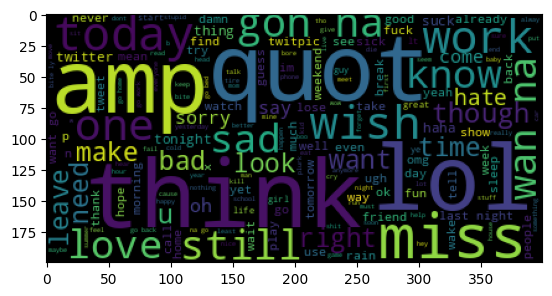

In [58]:
from wordcloud import WordCloud
wc = WordCloud().generate(" ".join(gp.get_group("Negative")["Text"]))
plt.imshow(wc)
plt.show()

In [59]:
Counter(jt).most_common(10)

[(';', 79504),
 ('get', 65214),
 ('go', 54923),
 ('good', 49720),
 ('love', 44556),
 ('thank', 40642),
 ('day', 38505),
 ('http', 37738),
 ('quot', 36647),
 ('like', 32161)]

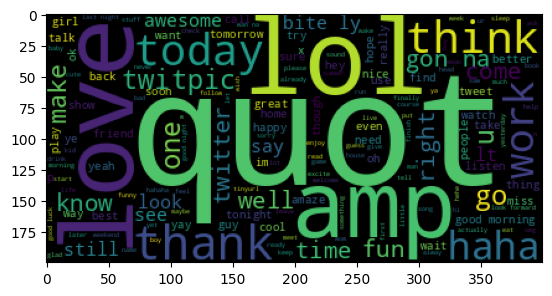

In [60]:
from wordcloud import WordCloud
wc = WordCloud().generate(" ".join(gp.get_group("Positive")["Text"]))
plt.imshow(wc)
plt.show()

### 6.Feature engineering

In [61]:
cv = CountVectorizer()    # it will take CountVectorizer function
final_bow = cv.fit_transform(x_train)  # create a spaese matrix for bag of words technique

### 7.Training

In [62]:
from sklearn.naive_bayes import BernoulliNB,MultinomialNB,CategoricalNB

In [66]:
mb = MultinomialNB()
model = mb.fit(final_pipe.fit_transform(x_train),y_train)

In [67]:
pickle.dump(model,open(r"/content/drive/MyDrive/twitter analysis/model.pkl","wb"))

### 8.Model evaluation

In [68]:
from sklearn.metrics import accuracy_score , classification_report

In [69]:
accuracy_score(y_test,model.predict(final_pipe.transform(x_test)))  # By using bernouli it will give 76% of accuracy rate

0.764075

In [70]:
print(classification_report(y_test,model.predict(final_pipe.transform(x_test))) )

              precision    recall  f1-score   support

           0       0.75      0.79      0.77    160000
           4       0.78      0.74      0.76    160000

    accuracy                           0.76    320000
   macro avg       0.76      0.76      0.76    320000
weighted avg       0.76      0.76      0.76    320000



### 9.Testing

In [71]:
m = final_pipe.transform(x_test.iloc[[1]])  # convert text into sprse matrix used by transform() method
pred = model.predict(m)   # it is used to shows that predicted value

if pred == 0:
    print("Negative")
else:
    print("Positive")

Negative


### 10.Conclusion

The conclusion of the Twitter analysis aims to predict the sentiment of tweets, categorizing them as either positive or negative. Through comprehensive data mining and sentiment analysis techniques, patterns emerged revealing distinct characteristics associated with each sentiment class. By leveraging machine learning algorithms such as Naive Bayes accurate predictions were achieved. The analysis underscores the importance of sentiment analysis in understanding public opinion and can be instrumental in various applications such as brand perception monitoring, market sentiment analysis, and political sentiment tracking. Additionally, it emphasizes the potential of leveraging social media data for real-time insights into public sentiment, thereby aiding decision-making processes across different domains.




